# Exercise Sheet 2 - MNIST Classification with PyTorch

 * Deep Learning – Winter term 2019/20
 * Instructor: Alexander Ecker
 * Tutor: Peter Chronz
 * Due date: Jan 6, 2020 at noon

# IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient

Implementation
- Only change code to replace placeholders. Leave the other code as is.


## Questions
* **There are seven cells with questions throughout the notebook. Make sure to answer those questions in the empty cell below.**
* In addition to the question cells there are code exercises marked in the code cells. Just fill in the placeholders, which are marked like so: `<PUT IN SOME CODE HERE>`

# PyTorch

We will be using PyTorch as our framework throughout the rest of the term. Some of the basics are explained in this exercise and implemented for you already, but it is not meant to be a comprehensive tutorial for learning PyTorch. Please refer to the excellent online resources:

 - Documentation: https://pytorch.org/docs/
 - Tutorials: https://pytorch.org/tutorials/

## Setup/requirements (skip if using Colab)

If you're not using Colab, install the required libraries before running this notebook.
* fastprogress for progress bars during training
* matplotlib to plot loss
* seaborn to plot the confusion matrix as a heatmap
* pytorch and torchvision for most of the operations

Choose the installation method based on your system. All tested with the Anaconda setup, but it should be fine via pip3 as well. Note that pip3 might simply be pip on your system.

If you're missing any of the dependencies, you can uncomment the code below. Choose either the Anaconda version or the python version. You might need to install Anaconda first.

### Anaconda

In [0]:
#This code is not running like this!
#I had to download the Anaconda Tool and insert it into the 'Anaconda Prompt', but without the !

# !conda install -c fastai fastprogress
# !conda install -c conda-forge matplotlib
# !conda install -c anaconda seaborn
# !conda install pytorch torchvision cudatoolkit=10.1 -c pytorch # with CUDA

### Pip

In [0]:
# !pip3 install fastprogress
# !pip3 install matplotlib
# !pip3 install seaborn
# !pip3 install torch torchvision

## Imports

In [1]:
import os
import pathlib
import random

import fastprogress
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms

## System checks

Perform some rudimentary system checks. Do we have a CUDA-capable device? Multiple? Is CuDNN active (huge speedups for some networks)?

In [75]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(False, True, 0)

Choose your device for computation. CPU or one of your CUDA devices?

In [3]:
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'

'cpu'

How many CPUs do we have? Use that as a guide to set the # of workers for multiprocessing in the data loader.

In [4]:
num_cpus = os.cpu_count()
num_cpus

4

## Prepare the data

Set the data dir and download the MNIST dataset to that location.

In [5]:
data_dir = pathlib.Path('data/')

Get the data set. We will use a popular data set, which is already integrated with pytorch. However, it's quite easy to implement your own dataset.

A data set is a subclass of ``DataSet`` (https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset). DataSet `implements` ``__len__`` and ``__get_item__``, which allow it to be used by a data loader.

https://pytorch.org/docs/stable/torchvision/datasets.html#mnist

In [76]:
mnist_train = datasets.MNIST(data_dir, download=True, train=True)

Create a data loader (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for our data set. Adjust the batch size, so that the batches (incl. the net) fit snuggly into memory. Generally, larger batch sizes are better. Adjust the number of workers; play around and notice the impact on your iteration speed. How fast is your memory access and your FS access (quad channel memory and NVMe SSDs are nice)?

While the data set provides access to the raw data, the data loader provides higher level access to the data.
For example, the data loader
* packs data points into batches,
* shuffles the data,
* loads data in parallel, by managing workers.

Review the data. It's always a good idea to have checkpoints to make sure that things work.
Since DataSet implements ``__len__`` and ``__getitem__``, **we can access the data as if it were a list**!

In [77]:
# <SELECT THE FIRST ELEMENT FROM THE DATA SET HERE. WHAT'S INSIDE?>
x, y = mnist_train[0]

We see that the dataset provides a tuple: (x, y). x is the image, y is the class.

Let's look at some random images (always a good idead if possible). 
Instead of rendering the image in code, just return the image to Jupyter, which will then recognize it as a PIL.Image and render automatically. 
Run this cell a couple of time to make sture that the labels are correct and to get a feeling for the data.

In [8]:
i = 56 #we have to set i to a vaule, otherwise it is not initializised!

In [78]:
# <CHOOSE A RANDOM ELEMENT FROM THE DATASET HERE. THEN RUN THE CELL MULTIPLE TIMES BY HAND.>
i += 1
x, y = mnist_train[i]
print(y)
x

4


How many data points are there in the dataset?

In [10]:
# <OBTAIN AND PRINT OUT THE LENGHT OF THE DATA SET>
len(mnist_train)

#we have 60000 entries in our train dataset

60000

## Pre-process the data

We have seen above that the contents of the data set are of type ``[(PIL.Image.Image, Int)]``. However, pytorch (the core that is, not torchvision or torchtext) is only equipped to work on Tensor objects. So we need to transform ``PIL.Image.Image`` to ``torch.Tensor``. Torchvision takes care of that for us. ``transforms.ToTensor`` is a transformation operation that maps a ``PIL.Image.Image`` to a troch tensor.

Furthermore, we will normalize the data to zero-mean and unit-variance. ``transforms.Normalize`` takes the mean and std-dev for each channel and rescales the data to zero-mean, unit-variance. https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize

We can combine multiple transformations via ``transforms.Compose``.

So let's create a new dataset with those transformations in-place.

In [89]:
batch_size = 256

In [90]:
mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [91]:
mnist_train = datasets.MNIST(data_dir, download=True, train=True, transform=mnist_transforms)

In [92]:
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_cpus//1)

Let's also create a validation set from the test set.

In [93]:
# LOAD THE MNIST TEST SET AS VALIDATION SET
#if train is set to False, it creates a dataset from test.pt
mnist_val = datasets.MNIST(data_dir, download=True, train=False)

print(mnist_val)
print(len(mnist_val))

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
10000


In [94]:
# CREATE A VALIDATION DATA LOADER
#first transform the dataset as the train dataset before
mnist_val = datasets.MNIST(data_dir, download=True, train=True, transform=mnist_transforms)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=True, num_workers=num_cpus//1)
#take the same batchsize as before, but change the used dataset

Let's get a data point now to see what we're dealing with.

In [95]:
x, y = next(iter(train_dataloader))
x, y

(tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           ...,
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],
 
 
         [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           ...,
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],
 
 
         [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
       

If you you're wondering about that ``next(iter(.))``-business check out how python's iterator protocol works. It's simple and will give you an important insight into python: https://wiki.python.org/moin/Iterator

***QUESTION 1:*** How does the element access above work? What do the functions do?

***SOLUTION:*** 

Iter is only defined for an iterable object, that means that _iter_ is defined for the object. If next is implemented as well, it is possible to get the next element of the object until there are no more elements avaible. 
In the easiest case itter will return it self or if there is only one element. 

In more the less a loop, it calls next until it reaches "StopIteration", so there are no more elements are avaible and the 'loop' ends. In this case the number of batches defines the number of iterations.

we set: batch_size = 256
and we get: len(x) = len(y) = 256

It is also possible to use it in 'for-loops', so to construct with result a loop again.

The data loader gives us two tensors. The first is a tensor with dimensons:

In [96]:
x.shape
#shape returns in this case the size of an torch object

torch.Size([256, 1, 28, 28])

and the second has dimensions:

In [97]:
y.size()

torch.Size([256])

(``.shape`` and ``.size()`` are both valid and used interchangably throughout pytorch.)

x has size (4, 1, 28, 28) --> 4 batches (or whatever you have defined in your data loader), 1 channel (the images are monochrome), 28 height/rows, 28 width/cols.

y has size (4) --> 4 batches (again depends on your data loader config). There's one label for each of the images in the batch.

How about the mean of a couple of batches? Should be approx. 0. Extra exercise compute the std. dev. as well.
Let's create a new data loader first, that will load only a subset of the data. A data loader that loadds only a subset is often great to iterate quickly through experiments/parameters early on in the training.

***QUESTION 2:*** To get a datloader that operates on a subset of a given data set, you can provide the data loader with a custom sampler. For this exercise define a sampler that will load random samples from a subset of the data set. The PyTorch docs are your friend!

***SOLUTION:*** TODO

In [98]:
# DEFINE A SAMPLER THAT WILL LOAD RANDOM SAMPLES FROM A SUBSET OF THE DATASET
sampler = torch.utils.data.RandomSampler(mnist_train) #or: 
#sampler =torch.utils.data.RandomSampler(mnist_train, replacement=True, num_samples=5)
#https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler
#if a sampler is used, shuffle has to be False! (standard)
subset_loader = torch.utils.data.DataLoader(mnist_train, batch_size=4, num_workers=num_cpus//1, sampler=sampler)

In [99]:
means = [x.mean() for x, _ in subset_loader]
torch.stack(means).mean()

tensor(-0.0001)

## Create a model

Now we're going to define the model that we're going to train on the data. Let's go for a simple, fully connected network also called multi-layer perceptron (MLP). An MLP consists of multiple fully connected layers with activation functions in between. In pytorch a fully connected layer is called *linear* layer. We'll use a sigmoid as activation functions within the network and a softamx for the categorical output.

Nets are defined as composable modules. Typically one would implement the initialization and the forward function. ``__init__`` usually instantiates sub-modules, while forward uses those modules to compute the forward function. The backward pass is performed automatically with autograd, which is the core feature of pytorch.

### Define the archtiecture

Now we need to define a net to train on our data. Let's use a simple MLP with three linear layers and some activation function (ReLU, LeakyReLU, Sigmoid, tanh?). The second layer should have the same amount of inputs as the initial layer. The last layer should have half as many inputs as the middle layer. 

Look up ``nn.Linear`` in the PyTorch docs. What should the input size be? How many elements are in the input data?

Also lookup potential activation functions.

In the forward function first "flatten" the input vector. The input vector will be of size (BATCH_SIZE, 28, 28). However, the linear layers only take data of size (BATCH_SIZE, N). So, you need to flatten the last two dimensions. There's a vector operation for this purpose in PyTorch. Then run the input data through all your layers in the proper sequence.

In general in PyTorch most operations happen on (BATCH_SIZE, ...) because batches are computed in parallel on GPUs. So most of the time the BATCH_SIZE is there implicitly in operations and tensors.

Hint for the output layer: you need to have an output of size (BATCH_SIZE, 10) for our loss function to work. Again, the batch size is implicit in the definition of the output layer.

In [0]:
class MLP(nn.Module):
    def __init__(self, num_layers=1):
        super().__init__()
        
        layers = [nn.Linear(a,a),  # <DEFINE INPUT ANd OUTPUT FOR THE LINEAR LAYER>),
                  nn.Linear(a,b),  #a und b sind nur Platzhalter, mit b=a/2 siehe Aufgabe, 10 da wir 10 Zahlen haben
                  nn.Linear(b,10)] #und output des vorherigen muss gleich input des nächsten sein!
        # DEFINE ACTIVATION FUNCTIONS AND MORE LAYERS
        self.lls = nn.Sequential(*layers)
    
    def forward(self, x):
        batch_size = x.shape[0]
        #x = x.flatten() #
        # <FLATTEN THE INPUT TO A SUITABLE SIZE FOR THE INITIAL LINEAR LAYER>
        # <RUN THE DATA THROUGH ALL OF YOUR LAYERS>
        return x

In [128]:
class MLP(nn.Module):
    def __init__(self, num_layers=1):
        super().__init__()
        #three layers in my neural network
        self.input_layer = nn.Linear(784,784) 
        self.hidden_layer = nn.Linear(784,392)
        self.output_layer =nn.Linear(392,10)
    
    def forward(self, x):
        batch_size = x.shape[0] #get the batch-size
        res = [] #to store the results
        for i in range(batch_size): #to loop the function over all batches
            x_i = x[i] #x_i is the actuall input we look at
            x_i = x_i.flatten() #flatten the input
            x_i = F.relu(self.input_layer(x_i)) #apply the activation-fct to the input-layer
            x_i = F.relu(self.hidden_layer(x_i)) 
            x_i = F.softmax(self.output_layer(x_i)) #applay the softmax to the output_layer to generate the output
            res.append(x_i)
        return res
        
    

#model = MLP()
#model = model(x)
#print(mod)
k = 0
#print(mod(x)) #prediction: 8 or 7- highest prob, depends on how they count
#print(max(mod(x)))
#print(y[k]) #result: 8

### Instantiate the model

In [129]:
model = MLP(num_layers=1).to(device)

Let's take a look a look at the inside of our model. It's always a good idea to verify that the actual architecture is what you intended it to be. Especially, when you start to create layers dynamically it's great for inspection/verification/debugging.

In [130]:
model

MLP(
  (input_layer): Linear(in_features=784, out_features=784, bias=True)
  (hidden_layer): Linear(in_features=784, out_features=392, bias=True)
  (output_layer): Linear(in_features=392, out_features=10, bias=True)
)

## Define a loss function

So far we've avoided to define the final layer activation in our net. Since we're deadling with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values $\in [0, 1]$ that sum to 1 over all categories.

The softmax function typically goes hand-in-hand with negative log-likelihood (NLL) as loss function. So, naively, one would set the final layer activation to softmax and then the loss to NLL. However, NLL expects log-probablities, but softmax provides probabilities. Thus, we would need to compute the log of softmax's output. This approach in turn leads to numerical instabilities, which in turn make it harder for your net to converge. One solution is to use ``LogSoftmax``, which computes the log probabilities from the softmax direclty. It's numerically stable and faster, than the manual approach. An alternative, but functionally equivalent, approach is to skip the final layer activation and to use ``nn.functional.cross_entropy``. This is a loss function that combines ``LogSoftmax`` and ``NLLLoss`` . 

In [103]:
loss_fn = F.cross_entropy

## Define the optimizer

Let's use Adam as optimizer, since it's robust and thus easy to use. We need to pass the model parameters to the optimizer, because the optimizer needs to adjust thos based on the accumulated gradients after backprop.

Look up how to set the learning rate with Adam and **initialize the optimizer below with a learning rate of 1e-4**.

In [131]:
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999)) 

## Train

In [132]:
train_loss, val_loss = [], []

Let's define the inner training loop.

In [133]:
def accuracy(correct, total): return float(correct)/total
    
def train(dataloader, optimizer, model, loss_fn, train_loss, device, master_bar):
    epoch_loss = []
    epoch_correct = 0
    epoch_total = 0
    # <LOOP OVER THE DATA LOADER AND USE fastprogress.progress_bar WITH master_bar FOR OUTPUT>
    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()
        y_pred = model(x.to(device))
        hits = y == y_pred.argmax(dim=1)
        epoch_correct += sum(hits)
        epoch_total += len(hits)
        loss = loss_fn(y_pred, y.to(device))# <MOVE THE LABEL TO YOUR DEVICE AND COMPUTE THE LOSS>
        gradients = loss.backward() ## <COMPUTE THE GRADIENTS IN A BACKWARD PASS>
        optimizer.step(gradients) ## <USE THE COMPUTED GRADIENTS TO PERFORM AN OPTIMIZATION STEP> optimizer.step()
        epoch_loss.append(loss.item())
        averaged_loss = sum(epoch_loss[-50:])/len(epoch_loss[-50:])
        master_bar.child.comment = f'Train loss: {averaged_loss:.2f}, train accuracy: {accuracy(epoch_correct, epoch_total):.3f}'
    train_loss.extend(epoch_loss)
    epoch_accuracy = accuracy(epoch_correct, epoch_total)
    return epoch_loss, epoch_accuracy

def validate(dataloader, model, loss_fn, val_loss, device, master_bar):
    # XXX Using a plain list and appending to it can a) be slow b) lead to memory leaks!
    # Use something like a ring buffer for things you want to re-use here in code and
    # tensorboardx for training metrics in larger setups.
    epoch_loss = []
    confusion = torch.zeros(10, 10)
    epoch_correct = 0
    epoch_total = 0
    epoch_misclassified = []
    confusion = torch.zeros(10, 10, dtype=torch.int32)
    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        model.eval()
        y_pred = model(x.to(device))
        y_pred_idxs = y_pred.argmax(dim=1)
        for (idx_true, idx_pred) in zip(y, y_pred_idxs):
            confusion[idx_true, idx_pred] += 1
        hits = y == y_pred_idxs
        epoch_correct += sum(hits)
        epoch_total += len(hits)
        misclassified = list(zip([x for x in x[~hits]], y[~hits]))
        epoch_misclassified.extend(misclassified)
        loss = loss_fn(y_pred, y.to(device))
        epoch_loss.append(loss.item())
        averaged_loss = sum(epoch_loss[-50:])/len(epoch_loss[-50:])
        master_bar.child.comment = f'Val loss: {averaged_loss:.2f}, train accuracy: {accuracy(epoch_correct, epoch_total):.3f}'
    epoch_accuracy = accuracy(epoch_correct, epoch_total)
    return epoch_loss, epoch_accuracy, epoch_misclassified, confusion

***Question 3:*** Why are we using `optimizer.zero_grad()` in the training loop for each batch? Why aren't we doing that in the validation loop as well?

***SOLUTION:*** 

1. Observe how gradient buffers had to be manually set to zero using optimizer.zero_grad(). This is because gradients are accumulated and need to clear it, because otherwise we will accumulate it to existing gradients.

2. We do not need in the validation loop, because there we do not want to train our model anymore. We also want to keep the history and accumlate it.

In [134]:
#error while running: AttributeError: module 'fastprogress' has no attribute 'master_bar'

num_epochs = 3
master_bar = fastprogress.master_bar(range(num_epochs))
for epoch in master_bar:
    epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, loss_fn, train_loss, device, master_bar)
    epoch_train_mean_loss = sum(epoch_train_loss)/len(epoch_train_loss)
    epoch_val_loss, epoch_val_acc, misclassified, confusion = validate(val_dataloader, model, loss_fn, val_loss, device, master_bar)
    epoch_val_mean_loss = sum(epoch_val_loss)/len(epoch_val_loss)
    master_bar.write(f'Train loss: {epoch_train_mean_loss:.2f}, val loss: {epoch_val_mean_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
    master_bar.update_graph([[range(len(epoch_train_loss)), epoch_train_loss]])

AttributeError: module 'fastprogress' has no attribute 'master_bar'

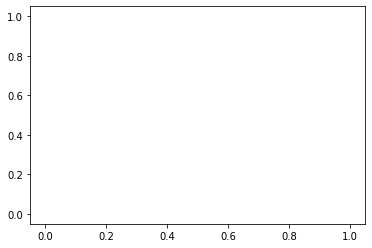

In [122]:
plt.plot(train_loss)

Let's take a look at random misclassified images. Misclassified images can give you a better feeling for well your classifier is doing and where it's weaknesses may lie. Are the misclassified images really hard to interpret? Are there any obvious patterns that the classifier doesn't get? Would you do better yourself?

In [123]:
len(misclassified)

NameError: name 'misclassified' is not defined

In [124]:
rand_miss_tensor, label = random.choice(misclassified)
rand_miss_tensor = TF.normalize(rand_miss_tensor, (-0.1307/0.3081,), (1/0.3081,))
rand_miss_image = TF.to_pil_image(rand_miss_tensor)
print(label)
rand_miss_image

NameError: name 'misclassified' is not defined

Let's take a look at the confusion matrix to get a feeling for the most misclassified numbers.

In [125]:
plt.figure(figsize=(10,7))
sn.heatmap(confusion, annot=True)

NameError: name 'confusion' is not defined

<Figure size 720x504 with 0 Axes>

**Exercise** Where do you see most misclassifications in the confusion matrix above? Which classes are misclassified in what way?

Problem, I can not se the figure/ confusion matrix. I do not know if my model is specified correctly.

Let's continue to train and see what happens. Btw. you can interrupt the execution by pressing `i` twice or with the "stop" button in the menu in Jupyter. In Colab press `Cmd/Ctrl+M` I or use the "Runtime" menu.

In [126]:
num_epochs = 1000
master_bar = fastprogress.master_bar(range(num_epochs))
for epoch in master_bar:
    epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, loss_fn, train_loss, device, master_bar)
    epoch_train_mean_loss = sum(epoch_train_loss)/len(epoch_train_loss)
    epoch_val_loss, epoch_val_acc, misclassified, confusion = validate(val_dataloader, model, loss_fn, val_loss, device, master_bar)
    epoch_val_mean_loss = sum(epoch_val_loss)/len(epoch_val_loss)
    master_bar.write(f'Train loss: {epoch_train_mean_loss:.2f}, val loss: {epoch_val_mean_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
    master_bar.update_graph([[range(len(epoch_train_loss)), epoch_train_loss]])

AttributeError: module 'fastprogress' has no attribute 'master_bar'

***QUESTION 4:*** What is you observation regarding the relation of the training metrics to the validation metrics? What does you observation hint at?

***SOLUTION:*** not possible to answer, is not working

***QUESTION 5:*** Modify the initialization of our optimizer to apply L2 weight decay for regularization. Try a value of 0.001 and then experiment a little. How does L2 regularization impact the results? Copy the necessary cells from above below this cell and modify the code as needed. Which value for L2 regularization did you find to work well?

***SOLUTION:***

In [0]:
# TODO copy cells from above and apply L2 regularization. 

***QUESTION 6:*** Instead of L2 regularization now use dropout. Add dropout layers after the activations in your network definition. Start with a drop out probability of 0.5 and then experiment with the parameter until you get satisfactory results. Again, copy only the required code from above, run it again and evaluate the results. Which *value* for dropout did you find to work well?

***SOLUTION:***

In [0]:
# TODO copy cells from above and apply dropout.

***QUESTION 7:*** Can you explain what the line `model.eval()` at the beginning of the validation loop in the function `validate()` defined above does and why it is necessary to include it when using dropout regularization?

***SOLUTION:*** TODO